In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import pandas as pd
import requests
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import random
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Functions and Data Loading

In [2]:
def random_smiles_tanimoto(filtered_pairs):

    pfam_id = random.choice(filtered_pairs['pfam_id'].unique())
    smiles_list = filtered_pairs[filtered_pairs['pfam_id'] == pfam_id]['SMILES'].unique()

    s1, s2 = random.sample(list(smiles_list), 2)

    mol1 = Chem.MolFromSmiles(s1, sanitize=True)
    mol2 = Chem.MolFromSmiles(s2, sanitize=True)

    # Check if either molecule failed to parse
    if mol1 is None or mol2 is None:
        return "Invalid"

    morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
    fp1 = morgan_gen.GetFingerprint(mol1)
    fp2 = morgan_gen.GetFingerprint(mol2)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [18]:
def random_embeddings_chemberta(model, filtered_pairs):
    
    pfam_id = random.choice(filtered_pairs['pfam_id'].unique())
    smiles_list = filtered_pairs[filtered_pairs['pfam_id'] == pfam_id]['SMILES'].unique()

    s1, s2 = random.sample(list(smiles_list), 2)
    inputs = tokenizer([s1, s2], return_tensors='pt', padding=True, truncation=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Use CLS token embedding (first token) as representation
        embeddings = outputs.last_hidden_state[:, 0, :]
    embeddings = embeddings.numpy()
    
    return embeddings

In [10]:
def compare_multiple_embeddings(model, filtered_pairs, iterations=1000):
    cosine_distances, cosine_similarities = [], []
    for k in range(iterations):
        if k%100==0: print(k)
        embeddings = random_embeddings_chemberta(model, filtered_pairs)
        cosine_distances.append(cosine(embeddings[0], embeddings[1]))
        cosine_similarities.append(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])
    return cosine_distances, cosine_similarities

In [4]:
data = pd.read_csv("~/Projects/ReverseLigQ_2/interactions_DB.csv", index_col = 0)
data

,pdb_id,ligand_chain_id,ligand_id,bm_id,res_chain_id,resid,resnum,SMILES,pfam_id,pfam_name
0,101M,A,HEM,bm2,A,TYR,103,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042,Globin
1,101M,A,HEM,bm2,A,LEU,104,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042,Globin
2,101M,A,HEM,bm2,A,ILE,107,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042,Globin
3,101M,A,HEM,bm2,A,PHE,138,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042,Globin
4,101M,A,HEM,bm2,A,THR,39,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042,Globin
...,...,...,...,...,...,...,...,...,...,...
5881918,9CLJ,A_27,IHP,bm99,A_27,LYS,25,C1(C(C(C(C(C1OP(=O)(O)O)OP(=O)(O)O)OP(=O)(O)O)...,NaN,NaN
5881919,9CLJ,A_27,IHP,bm99,A_27,LYS,25,C1(C(C(C(C(C1OP(=O)(O)O)OP(=O)(O)O)OP(=O)(O)O)...,NaN,NaN
5881920,9CLJ,A_27,IHP,bm99,A_27,LYS,25,C1(C(C(C(C(C1OP(=O)(O)O)OP(=O)(O)O)OP(=O)(O)O)...,NaN,NaN
5881921,9CLJ,A_27,IHP,bm99,A_27,LYS,25,C1(C(C(C(C(C1OP(=O)(O)O)OP(=O)(O)O)OP(=O)(O)O)...,NaN,NaN


In [5]:
smile_pfam_pairs = data[['SMILES', 'pfam_id']].dropna().drop_duplicates()
smile_pfam_pairs

,SMILES,pfam_id
0,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042
158,c1ccc(cc1)CSCC(C(=O)NC(c2ccccc2)C(=O)O)NC(=O)C...,PF14497
189,c1nc(c2c(n1)n(cn2)C3C(C(C(O3)CSCCC(C(=O)O)N)O)O)N,PF00145
258,c1nc(c2c(n1)n(cn2)C3C(C(C(O3)COP(=O)(O)OC4C(C(...,PF00074
282,c1nc2c(n1C3C(C(C(O3)COP(=O)(O)OC4C(C(OC4N5C=CC...,PF00074
...,...,...
5876495,c1ccc2c(c1)cccc2CNc3[nH]c4cc5c(cc4n3)C(=O)NC(=...,PF01702
5876541,c1ccc(cc1)C(c2ccc(cc2)c3c4c([nH]cn4)ncn3)N,PF00069
5876555,c1cc(ccc1c2c3c([nH]cn3)ncn2)C4(CCNCC4)c5ccc(cc...,PF00069
5876596,Cc1c(c[nH]n1)c2ccc(cc2)CCN,PF00069


In [6]:
# Step 1: Count how many times each pfam_id appears (i.e. how many unique SMILES it has)
pfam_counts = smile_pfam_pairs['pfam_id'].value_counts()

# Step 2: Filter to pfam_ids that appear at least twice
pfam_with_multiple_smiles = pfam_counts[pfam_counts >= 2].index

# Step 3: Filter the unique_pairs dataframe
filtered_pairs = smile_pfam_pairs[smile_pfam_pairs['pfam_id'].isin(pfam_with_multiple_smiles)]

filtered_pairs

,SMILES,pfam_id
0,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7...,PF00042
158,c1ccc(cc1)CSCC(C(=O)NC(c2ccccc2)C(=O)O)NC(=O)C...,PF14497
189,c1nc(c2c(n1)n(cn2)C3C(C(C(O3)CSCCC(C(=O)O)N)O)O)N,PF00145
258,c1nc(c2c(n1)n(cn2)C3C(C(C(O3)COP(=O)(O)OC4C(C(...,PF00074
282,c1nc2c(n1C3C(C(C(O3)COP(=O)(O)OC4C(C(OC4N5C=CC...,PF00074
...,...,...
5876495,c1ccc2c(c1)cccc2CNc3[nH]c4cc5c(cc4n3)C(=O)NC(=...,PF01702
5876541,c1ccc(cc1)C(c2ccc(cc2)c3c4c([nH]cn4)ncn3)N,PF00069
5876555,c1cc(ccc1c2c3c([nH]cn3)ncn2)C4(CCNCC4)c5ccc(cc...,PF00069
5876596,Cc1c(c[nH]n1)c2ccc(cc2)CCN,PF00069


# Tanimoto distribution

In [ ]:
tanimoto_values = [random_smiles_tanimoto(filtered_pairs) for k in range(10000)]

In [95]:
tanimoto_values = [k for k in tanimoto_values if type(k)!=str]

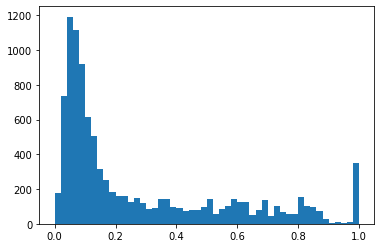

In [98]:
plt.hist(tanimoto_values, bins=50)
plt.show()

# CHEMBERTa distribution

## Comparison between SMILEs that bind the same Pfam domain

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = RobertaModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Make sure model is in evaluation mode
model.eval()

In [19]:
embeddings = random_embeddings_chemberta(model, filtered_pairs)
embeddings

array([[ 0.2620638 , -0.615782  , -0.5710712 , ..., -0.5373292 ,
        -0.2503488 ,  1.3675458 ],
       [ 0.40867192, -0.3828146 , -0.37193283, ..., -0.8736427 ,
        -0.35382625,  1.6185278 ]], dtype=float32)

In [20]:
cosine_distances, cosine_similarities = compare_multiple_embeddings(model, filtered_pairs, iterations=1000)

0
100
200
300
400
500
600
700
800
900


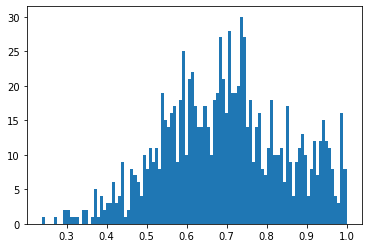

In [21]:
plt.hist(cosine_similarities, bins = 100)
plt.show()

## Comparison between completely random SMILEs

In [15]:
similarities = []
for k in range(1000):
    s1, s2 = random.sample(list(filtered_pairs.SMILES.unique()), 2)
    inputs = tokenizer([s1, s2], return_tensors='pt', padding=True, truncation=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Use CLS token embedding (first token) as representation
        embeddings = outputs.last_hidden_state[:, 0, :]
    embeddings = embeddings.numpy()
    
    similarities.append(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])

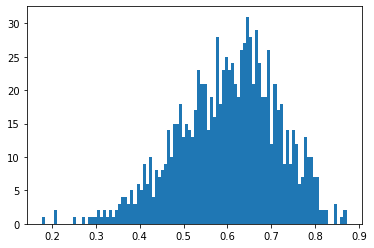

In [ ]:
plt.hist(similarities, bins = 100)
plt.show()